In [13]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import csv
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
# Connect to database using sqlite3
con = sql.connect("chinook.db")

In [3]:
# a) Write an SQL query to gather information about the artists, their albums, tracks, genres, and playlists. Import this information into a pandas data frame.

query = '''
    SELECT r.ArtistId,
        r.Name as Artist, 
        l.AlbumId, 
        l.Title as Album, 
        t.TrackId, 
        t.Name as Track, 
        g.GenreId, 
        g.Name as Genre, 
        p.PlaylistId, 
        p.Name as Playlist
    FROM Track t
    JOIN Album l USING(AlbumId)
    JOIN Artist r USING(ArtistId)
    JOIN Genre g USING(GenreId)
    JOIN PlaylistTrack USING(TrackId)
    JOIN Playlist p USING(PlaylistId);
    '''

music_df = pd.read_sql_query(query, con)

print(music_df)

      ArtistId         Artist  AlbumId  \
0            8     Audioslave      271   
1            8     Audioslave      271   
2            8     Audioslave      271   
3            8     Audioslave      271   
4            8     Audioslave      271   
...        ...            ...      ...   
8710       114  Ozzy Osbourne      171   
8711       114  Ozzy Osbourne      171   
8712       114  Ozzy Osbourne      172   
8713       179      Scorpions      257   
8714        68    Miles Davis       48   

                                                  Album  TrackId  \
0                                           Revelations     3402   
1                                           Revelations     3389   
2                                           Revelations     3390   
3                                           Revelations     3391   
4                                           Revelations     3392   
...                                                 ...      ...   
8710               

In [4]:
# 10 points) Select all the artists that have more than one album for the analysis below
grouped_df = music_df.groupby(['ArtistId']).filter(lambda x: x['AlbumId'].nunique() > 1)

print(grouped_df)

      ArtistId         Artist  AlbumId                               Album  \
0            8     Audioslave      271                         Revelations   
1            8     Audioslave      271                         Revelations   
2            8     Audioslave      271                         Revelations   
3            8     Audioslave      271                         Revelations   
4            8     Audioslave      271                         Revelations   
...        ...            ...      ...                                 ...   
8706        50      Metallica      154                  Ride The Lightning   
8710       114  Ozzy Osbourne      171                     Blizzard of Ozz   
8711       114  Ozzy Osbourne      171                     Blizzard of Ozz   
8712       114  Ozzy Osbourne      172      Diary of a Madman (Remastered)   
8714        68    Miles Davis       48  The Essential Miles Davis [Disc 1]   

      TrackId                                           Track  

In [27]:
top_genres = grouped_df.groupby('Genre').agg({'Track':'count'}).sort_values(['Track'], ascending=False).head(7).index

In [28]:
genre_df = grouped_df.groupby(['ArtistId'])[top_genres].sum()
filter_df = grouped_df.groupby(['ArtistId', 'Artist']).agg({'Album':'nunique', 'Track':'nunique', 'Playlist':'nunique'})
# Populate coluns with values
for genre in top_genres:
    filter_df[genre] = 0
    artists = genre_df.loc[genre].index
    for artist in artists:
        track_count = int(genre_df.loc[genre, artist])
        filter_df.loc[artist, genre] = track_count

filter_df.reset_index(inplace=True)
filter_df

KeyError: "Columns not found: 'Metal', 'Jazz', 'Rock', 'Latin', 'Blues', 'Alternative & Punk', 'TV Shows'"

In [18]:
# Subset data to select
cols = filter_df.columns.to_list()[2:]
k_data = filter_df[cols]

# Standardize data
std_data = StandardScaler().fit_transform(k_data)

In [9]:
inertia = []
k_vals = list(range(2, 12, 2))

# Determine inertia values
for k in k_vals:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(std_data)
    inertia.append(kmeans.inertia_)

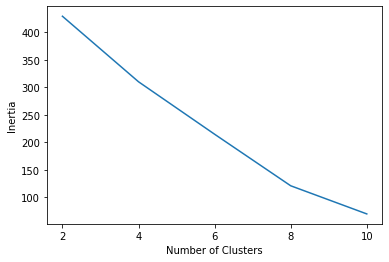

In [10]:
# Plotting
plt.plot(k_vals, inertia)
plt.xticks(k_vals)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [24]:
# Cluster with k=8
kmeans = KMeans(n_clusters=8)
kmeans.fit(std_data)

cluster_labels = kmeans.labels_

closest_artists = []
for k in range(8):
    cluster_indices = np.where(cluster_labels == k)[0]
    cluster_members = std_data[cluster_indices]
    centroid = kmeans.cluster_centers_[k]
    distances = distance.cdist([centroid], cluster_members, 'euclidean')[0]
    closest = distances.argsort()[:3]
    for idx in closest:
        df_original_idx = cluster_indices[idx]
        closest_distance = distances[idx]
        closest_artists.append({"Artist": filter_df.iloc[df_original_idx]["Artist"], "group_num": k, "centroid_dist": closest_distance})

df_closest = pd.DataFrame(closest_artists)
new_df = df_closest.merge(filter_df, on='Artist', how='left')

new_df

,Artist,group_num,centroid_dist,ArtistId,Album,Track,Playlist,Rock,Latin,Metal,Alternative & Punk,TV Shows,Jazz,Blues
0,Green Day,0,0.421434,54,2,34,2,0,0,0,83,0,0,0
1,Smashing Pumpkins,0,0.442987,131,2,34,2,0,0,0,85,0,0,0
2,The Tea Party,0,0.705562,143,2,22,2,0,0,0,76,0,0,0
3,Metallica,1,2.533658,50,10,112,3,0,0,296,0,0,0,0
4,Iron Maiden,1,2.533658,90,21,150,3,213,0,227,0,0,0,18
5,Tim Maia,2,0.293653,145,2,30,2,0,67,0,0,0,0,0
6,Cássia Eller,2,0.384323,77,2,30,2,0,62,0,0,0,0,0
7,Milton Nascimento,2,0.600851,42,2,26,2,0,55,0,0,0,0,0
8,The Office,3,1.030241,156,3,52,1,0,0,0,0,72,0,0
9,Lost,3,1.030241,149,4,91,1,0,0,0,0,96,0,0
